# Supplier Performance Analysis: Predicting On-Time Delivery from SAP ERP Data

This project analyzes SAP ERP procurement data to predict whether a supplier delivers purchase orders on time.  
We focus on data cleaning, exploration, and advanced analytics, aiming to build a predictive model for delivery performance.

**Author:** Yury Besiakov
**Dataset:** Kaggle [SAP BigQuery Dataset](https://www.kaggle.com/datasets/mustafakeser4/sap-dataset-bigquery-dataset/data)

**Business goal** : Cut expedite cost by predicting late POs  
**Target** : `on_time_flag` (1 = posting date ≤ promised date + 14)  
**Baseline** : majority class accuracy = *to be filled*  
**Metric** : F1‑score (class imbalance)  

In [75]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score

# Set plotting style for consistency
sns.set(style="whitegrid", palette="Set2")


# Data loading and cleaning
I’ll start with data cleaning and initial exploration on:
- Purchase order items (`ekpo`)
- Purchase order history (`ekbe`)
- Vendor master data (`lfa1`)
- Purchase order headers (`ekko`)


In [2]:
# Load CSV files
dtype_opts = {"dtype": str, "low_memory": False}

ekpo = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekpo.csv')
ekbe = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekbe.csv')
lfa1 = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/lfa1.csv')
ekko = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekko.csv')


/tmp/ipykernel_36/3356195582.py:4: DtypeWarning: Columns (3,4,7,8,50,51,58,85,101,115,163,166) have mixed types. Specify dtype option on import or set low_memory=False.
  ekpo = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekpo.csv')
/tmp/ipykernel_36/3356195582.py:5: DtypeWarning: Columns (21,22,32,37,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  ekbe = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekbe.csv')
/tmp/ipykernel_36/3356195582.py:7: DtypeWarning: Columns (5,6,12,38,46,47,53,67,95) have mixed types. Specify dtype option on import or set low_memory=False.
  ekko = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekko.csv')


## Quick Data Inspection
Check basic info, missing values, and head of each DataFrame.


In [3]:
for name, df in zip(["ekpo","ekbe","lfa1","ekko"],
                    [ekpo, ekbe, lfa1, ekko]):
    print(f"{name}: {df.shape[0]:,} rows  |  {df.shape[1]} cols")


ekpo: 125,724 rows  |  307 cols
ekbe: 123,997 rows  |  89 cols
lfa1: 3,035 rows  |  145 cols
ekko: 76,362 rows  |  143 cols


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Quick inspection function
def inspect(df, name):
    print(f"--- {name} ---")

    # Initial shape
    print("Shape before cleaning:", df.shape)
    
    # Count of columns with >80% NaNs BEFORE
    na_80_before = (df.isna().mean() > 0.8).sum()
    print(f"Columns with >80% missing values before cleaning: {na_80_before}")

    # Drop columns with >80% missing
    df = df.loc[:, df.isna().mean() <= 0.8]

    # Final shape
    print("Shape after cleaning:", df.shape)

    # Count of columns with >80% NaNs AFTER
    na_80_after = (df.isna().mean() > 0.8).sum()
    print(f"Columns with >80% missing values after cleaning: {na_80_after}")

    display(df.head())
    print("\n")
    return df

# Apply to datasets
ekpo = inspect(ekpo, "EKPO (PO Items)")
ekbe = inspect(ekbe, "EKBE (PO History)")
lfa1 = inspect(lfa1, "LFA1 (Vendor Master)")
ekko = inspect(ekko, "EKKO (PO Headers)")


--- EKPO (PO Items) ---
Shape before cleaning: (125724, 307)
Columns with >80% missing values before cleaning: 255
Shape after cleaning: (125724, 52)
Columns with >80% missing values after cleaning: 0


,mandt,ebeln,ebelp,aedat,txz01,matnr,ematn,bukrs,werks,lgort,...,inco2,drunr,mtart,bonba,tzonrc,creationdate,creationtime,operation_flag,is_deleted,recordstamp
0,250,4500000000,10,2022-01-17,Test Dry Good,TEST CPG1,TEST CPG1,USA1,1000,NaN,...,NaN,1,FERT,100.0,EST,2022-01-14,10:41:27,L,False,2022-01-31 20:42:02.329876+00:00
1,250,4500000002,10,2022-01-19,Test Dry Good,TEST CPG1,TEST CPG1,USA1,1000,NaN,...,NaN,1,FERT,200.0,EST,2022-01-19,15:15:51,L,False,2022-01-31 20:42:02.329876+00:00
2,250,4500000000,10,2022-02-22,Test Dry Good,TEST CPG1,TEST CPG1,USA1,1000,1001.0,...,NaN,1,FERT,100.0,EST,2022-01-14,10:41:27,U,False,2022-02-22 08:45:41.745178+00:00
3,250,4500000000,10,2022-02-25,Test Dry Good,TEST CPG1,TEST CPG1,USA1,1000,1001.0,...,NaN,1,FERT,100.0,EST,2022-01-14,10:41:27,U,False,2022-02-25 11:09:10.788204+00:00
4,250,4500000002,10,2022-02-25,Test Dry Good,TEST CPG1,TEST CPG1,USA1,1000,NaN,...,NaN,1,FERT,200.0,EST,2022-01-19,15:15:51,U,False,2022-02-25 11:09:10.788204+00:00




--- EKBE (PO History) ---
Shape before cleaning: (123997, 89)
Columns with >80% missing values before cleaning: 45
Shape after cleaning: (123997, 44)
Columns with >80% missing values after cleaning: 0


,mandt,ebeln,ebelp,vgabe,gjahr,belnr,buzei,bewtp,bwart,budat,...,ernam,arewb,rewrb,saprl,arewr_pop,vbeln_st,vbelp_st,operation_flag,is_deleted,recordstamp
0,250,4500000006,10,8,NaN,80000014,10,L,NaN,2022-01-21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00
1,250,4500000011,10,8,NaN,80000015,10,L,NaN,2022-01-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00
2,250,4500000012,10,8,NaN,80000016,10,L,NaN,2022-01-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00
3,250,4500000013,10,8,NaN,80000017,10,L,NaN,2022-01-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00
4,250,4500000014,10,8,NaN,80000018,10,L,NaN,2022-01-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00




--- LFA1 (Vendor Master) ---
Shape before cleaning: (3035, 145)
Columns with >80% missing values before cleaning: 112
Shape after cleaning: (3035, 33)
Columns with >80% missing values after cleaning: 0


,mandt,lifnr,land1,name1,ort01,ort02,pstlz,regio,sortl,stras,...,ltsna,werkr,duefl,txjcd,taxbs,ric,legalnat,operation_flag,is_deleted,recordstamp
0,800,0000001111,US,Suppliers Inc.,NILES,COOK,60714,NaN,AUTO/PUMPE,12 Western Avenue,...,NaN,NaN,X,1403120601,0.0,0.0,0.0,I,False,2021-03-31 02:47:30.036270+00:00
1,800,0000003920,US,Pyramid Systems,SANTA CLARA,SANTA CLARA,95050,CA,PYRAMID SY,3912 N. First Av.,...,NaN,NaN,X,0508531801,0.0,0.0,0.0,I,False,2021-03-31 02:47:30.036270+00:00
2,800,0000003411,US,Delta Steel Inc.,HOUSTON,MATANUSKA-SUSITNA BO,99694,AK,STEEL,Baker Str.,...,NaN,NaN,X,0217008451,0.0,0.0,0.0,I,False,2021-03-31 02:47:30.036270+00:00
3,800,0000003020,US,World Wide Computer Warehouse,SAN JOSE,SANTA CLARA,95120,CA,SOFT,101 North Industrial Drive,...,NaN,NaN,X,0508530701,0.0,0.0,0.0,I,False,2021-03-31 02:47:30.036270+00:00
4,800,AVPL,US,American Vice President Line,Oakland,ALAMEDA,94607,CA,APL,1234 Water Street,...,NaN,NaN,X,0500123501,0.0,0.0,0.0,I,False,2021-03-31 02:47:30.036270+00:00




--- EKKO (PO Headers) ---
Shape before cleaning: (76362, 143)
Columns with >80% missing values before cleaning: 112
Shape after cleaning: (76362, 31)
Columns with >80% missing values after cleaning: 0


,mandt,ebeln,bukrs,bstyp,bsart,statu,aedat,ernam,pincr,lponr,...,inco1,inco2,knumv,kalsm,stafo,upinc,lands,operation_flag,is_deleted,recordstamp
0,250,4500001085,EU01,F,UB,9,2022-02-10,MALVIYAH,10,10,...,NaN,NaN,1.000001e+09,RM2000,SAP,1,NL,I,False,2022-02-10 07:05:37.818099+00:00
1,250,4500001086,EU01,F,UB,9,2022-02-10,MALVIYAH,10,10,...,NaN,NaN,1.000001e+09,RM2000,SAP,1,NL,I,False,2022-02-10 07:17:27.942806+00:00
2,250,4500001192,EU01,F,UB,9,2022-02-24,MALVIYAH,10,10,...,NaN,NaN,1.000001e+09,RM2000,SAP,1,NL,I,False,2022-02-24 06:53:25.370603+00:00
3,250,4500000024,USA1,F,UB,9,2022-01-25,MALVIYAH,10,10,...,NaN,NaN,1.000000e+09,RM2000,SAP,1,US,L,False,2022-01-31 20:42:01.546635+00:00
4,250,4500000030,USA1,F,UB,9,2022-01-28,MALVIYAH,10,10,...,NaN,NaN,1.000000e+09,RM2000,SAP,1,US,L,False,2022-01-31 20:42:01.546635+00:00


## Data Cleaning Steps

- Remove duplicates  
- Handle missing values (focus on critical columns)
- Ensure consistent datatypes (e.g., date columns as datetime)
- Basic filtering for realistic entries (e.g., positive quantities, valid vendor numbers)
- Keep only records with essential keys/quantities; convert key date columns.

In [5]:
#ekpo.columns

In [6]:
# Remove Duplicates
ekpo.drop_duplicates(inplace=True)
ekbe.drop_duplicates(inplace=True)
lfa1.drop_duplicates(inplace=True)
ekko.drop_duplicates(inplace=True)

# Handle Missing Values (report and clean critical ones)
critical_ekpo = ['ebeln', 'ebelp', 'matnr', 'menge']
critical_ekbe = ['ebeln', 'ebelp', 'budat', 'menge']
critical_lfa1 = ['lifnr']
critical_ekko = ['ebeln', 'lifnr', 'bedat']

for col in critical_ekpo:
    ekpo = ekpo[ekpo[col].notnull()]

for col in critical_ekbe:
    ekbe = ekbe[ekbe[col].notnull()]

for col in critical_lfa1:
    lfa1 = lfa1[lfa1[col].notnull()]

for col in critical_ekko:
    ekko = ekko[ekko[col].notnull()]

# Datatype Conversions
date_columns_ekbe = ['budat', 'cpudt']
for col in date_columns_ekbe:
    if col in ekbe.columns:
        ekbe[col] = pd.to_datetime(ekbe[col], errors='coerce')

if 'bedat' in ekko.columns:
    ekko['bedat'] = pd.to_datetime(ekko['bedat'], errors='coerce')

# 3.4 Filter for realistic entries (example: positive quantities)
ekpo = ekpo[ekpo['menge'] > 0]
ekbe = ekbe[ekbe['menge'] > 0]


## Consistency Checks & Merging Keys

check key relationships:
- `ebeln` (PO Number): exists in `ekpo`, `ekbe`, `ekko`
- `ebelp` (Item Number): `ekpo` & `ekbe`
- `lifnr` (Vendor): `ekpo`, `ekko`, `lfa1`


In [7]:
# How many unique POs and Vendors?
print(f"POs in EKPO: {ekpo['ebeln'].nunique()}, in EKBE: {ekbe['ebeln'].nunique()}, in EKKO: {ekko['ebeln'].nunique()}")

# Vendors: Only in LFA1 and EKKO, NOT in EKPO!
print(f"Vendors in LFA1: {lfa1['lifnr'].nunique()}, in EKKO: {ekko['lifnr'].nunique()}")

# Do all PO numbers in EKPO exist in EKKO?
missing_ekko = set(ekpo['ebeln']) - set(ekko['ebeln'])
print(f"POs in EKPO not in EKKO: {len(missing_ekko)}")


POs in EKPO: 69428, in EKBE: 63222, in EKKO: 69424
Vendors in LFA1: 2590, in EKKO: 44
POs in EKPO not in EKKO: 4


In [8]:
# remove POs in EKPO that are not in EKKO
ekpo = ekpo[ekpo['ebeln'].isin(ekko['ebeln'])]

In [9]:
#for df in [ekpo,ekbe,ekko]:
    #print(df.columns)

Index(['mandt', 'ebeln', 'ebelp', 'aedat', 'txz01', 'matnr', 'ematn', 'bukrs',
       'werks', 'lgort', 'matkl', 'infnr', 'menge', 'meins', 'bprme', 'bpumz',
       'bpumn', 'umrez', 'umren', 'netpr', 'peinh', 'netwr', 'brtwr', 'mwskz',
       'spinf', 'prsdr', 'elikz', 'pstyp', 'wepos', 'repos', 'webre', 'lmein',
       'evers', 'prdat', 'bstyp', 'effwr', 'stafo', 'plifz', 'ntgew', 'gewei',
       'bstae', 'inco1', 'inco2', 'drunr', 'mtart', 'bonba', 'tzonrc',
       'creationdate', 'creationtime', 'operation_flag', 'is_deleted',
       'recordstamp'],
      dtype='object')
Index(['mandt', 'ebeln', 'ebelp', 'vgabe', 'gjahr', 'belnr', 'buzei', 'bewtp',
       'bwart', 'budat', 'menge', 'bpmng', 'dmbtr', 'wrbtr', 'waers', 'arewr',
       'shkzg', 'elikz', 'lfgja', 'lfbnr', 'lfpos', 'cpudt', 'cputm', 'reewr',
       'refwr', 'matnr', 'werks', 'etens', 'mwskz', 'ematn', 'areww', 'hswae',
       'bamng', 'bldat', 'ernam', 'arewb', 'rewrb', 'saprl', 'arewr_pop',
       'vbeln_st', 'vbelp_st

In [10]:
# List key columns by df
ekpo_key_cols = ['menge', 'netpr', 'netwr', 'brtwr', 'effwr', 'aedat', 'prdat', 'creationdate']
ekbe_key_cols = ['menge', 'bpmng', 'lsmng', 'bamng', 'dmbtr', 'wrbtr', 'reewr', 'refwr', 'arewr', 'budat', 'cpudt', 'bldat']
ekko_key_cols = ['aedat', 'bedat']

# Function to report NA counts
def report_na(df, cols, dfname):
    print(f"\nMissing values in {dfname}:")
    print(df[cols].isnull().sum().sort_values(ascending=False))
    
report_na(ekpo, [col for col in ekpo_key_cols if col in ekpo.columns], 'EKPO')
report_na(ekbe, [col for col in ekbe_key_cols if col in ekbe.columns], 'EKBE')
report_na(ekko, [col for col in ekko_key_cols if col in ekko.columns], 'EKKO')



Missing values in EKPO:
netpr           15
netwr           15
brtwr           15
effwr           15
prdat            8
menge            0
aedat            0
creationdate     0
dtype: int64

Missing values in EKBE:
arewr    63330
reewr    63259
refwr    63259
bamng    60755
bpmng       46
dmbtr       40
wrbtr       40
bldat       17
menge        0
budat        0
cpudt        0
dtype: int64

Missing values in EKKO:
aedat    0
bedat    0
dtype: int64


## 🧹 Data Cleaning: Handling Missing Values

### Overview

Before proceeding with analysis, it's crucial to address missing values in key columns related to quantities, amounts, and dates. These fields are central to understanding supplier performance and are often required for any kind of modeling or visualization.

### Key Columns and Their Meanings

- **menge**: Quantity ordered (EKPO) or movement quantity (EKBE)
- **netpr**: Net price per unit (EKPO)
- **netwr**: Net value of the purchase order item (EKPO)
- **brtwr**: Gross value of the PO item (EKPO)
- **effwr**: Effective order value (EKPO)
- **prdat**: Requested delivery date (EKPO)
- **aedat**: Document (change/creation) date (EKPO/EKKO)
- **creationdate**: Date this data row was created in the system (EKPO)
- **bpmng, lsmng, bamng**: Various quantity fields in different units (EKBE)
- **dmbtr, wrbtr, arewr, refwr, reewr**: Various amount fields in different currencies and contexts (EKBE)
- **budat, bldat, cpudt**: Posting/document/entry dates (EKBE)
- **bwart**: Movement type code (EKBE); identifies the type of goods movement such as goods receipt (101), goods issue, returns, etc.


### Missing Value Handling Strategy

- **Drop rows** with missing values in critical columns that are needed for performance and financial analysis (such as quantities, prices, values, and dates).
    - In the data, only a small number of rows are missing values in these fields, so dropping them will not impact the overall analysis.
- **Retain NAs** in columns with a large number of missing values, especially when these fields are only relevant for specific document types or scenarios (e.g., certain quantities or amounts in EKBE). These will be left as NA for now, but may be filled with zero or further analyzed in advanced modeling if needed.

### Rationale

This approach ensures:
- High data quality for analysis and modeling
- Maximum use of available data, while ensuring that key metrics are never calculated with missing or unreliable values
- Transparency in the data cleaning process for any future reviewer or stakeholder

In [65]:
#check Various amount fields in different currencies and contexts (EKBE) are not negative
ekbe[['dmbtr','wrbtr', 'arewr', 'refwr', 'reewr']]
sum(ekbe['dmbtr']<0),sum(ekbe['wrbtr']<0), sum(ekbe['arewr']<0),sum(ekbe['refwr']<0), sum(ekbe['reewr']<0)


(0, 0, 0, 0, 0)

In [11]:
#Keep only goods‑receipt movement types 101 & 105
ekbe = ekbe.dropna(subset=[('bwart')])
ekbe = ekbe[ekbe['bwart'].astype(int).isin([101, 105])]
ekbe.reset_index(drop=True, inplace=True)

# EKPO: Drop rows missing critical values or delivery date
ekpo_clean = ekpo.dropna(subset=['netpr', 'netwr', 'brtwr', 'effwr', 'prdat'])

# EKBE: Drop rows missing small number of criticals (bpmng, dmbtr, wrbtr, bldat)
ekbe_clean = ekbe.dropna(subset=['bpmng', 'dmbtr', 'wrbtr', 'bldat'])




# Date Conversion and Logical Consistency Checks

I converted all relevant columns to datetime.  
Next, we ensured that planned or actual delivery/receipt dates never precede order dates.  
Records violating this business logic were removed for robust analysis.


In [12]:
# Helper function to safely convert to datetime
def to_datetime_safe(df, col):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Converted {col} to datetime.")

# List of date columns per DataFrame
ekpo_dates = ['aedat', 'prdat', 'creationdate']
ekko_dates = ['aedat', 'bedat']
ekbe_dates = ['budat', 'cpudt', 'bldat']

for col in ekpo_dates:
    to_datetime_safe(ekpo, col)
for col in ekko_dates:
    to_datetime_safe(ekko, col)
for col in ekbe_dates:
    to_datetime_safe(ekbe, col)


Converted aedat to datetime.
Converted prdat to datetime.
Converted creationdate to datetime.
Converted aedat to datetime.
Converted bedat to datetime.
Converted budat to datetime.
Converted cpudt to datetime.
Converted bldat to datetime.


In [13]:
# Merge EKPO (delivery date) with EKKO (order date) using PO number (ebeln)
if 'prdat' in ekpo.columns and 'bedat' in ekko.columns:
    ekpo_ekko_dates = ekpo.merge(ekko, on='ebeln', how='inner')
    # Logical test
    inconsistent = ekpo_ekko_dates[ekpo_ekko_dates['prdat'] < ekpo_ekko_dates['bedat']]
    print(f"Found {len(inconsistent)} records where delivery date < order date.")
    # filter out the inconsist values:
    ekpo_ekko_dates = ekpo_ekko_dates[ekpo_ekko_dates['prdat'] >= ekpo_ekko_dates['bedat']]


Found 194 records where delivery date < order date.


In [14]:
# Merge actual receipt date (budat, EKBE) with order date (bedat, EKKO)
if 'budat' in ekbe.columns and 'bedat' in ekko.columns:
    ekbe_ekko_dates = ekbe.merge(ekko, on='ebeln', how='inner')
    inconsistent2 = ekbe_ekko_dates[ekbe_ekko_dates['budat'] < ekbe_ekko_dates['bedat']]
    print(f"Found {len(inconsistent2)} records where actual receipt < order date.")
    # filter out the inconsist values:
    ekbe_ekko_dates = ekbe_ekko_dates[ekbe_ekko_dates['budat'] >= ekbe_ekko_dates['bedat']]


Found 40 records where actual receipt < order date.


In [15]:
# After merging, drop duplicate columns
def deduplicate_cols(df):
    # Find all .x/.y duplicates
    dup_cols = set([col[:-2] for col in df.columns if col.endswith('_x')]) & \
               set([col[:-2] for col in df.columns if col.endswith('_y')])
    for base_col in dup_cols:
        # Keep .x by default, or .y if .x is all null
        if df[base_col + '_x'].notnull().sum() >= df[base_col + '_y'].notnull().sum():
            df[base_col] = df[base_col + '_x']
        else:
            df[base_col] = df[base_col + '_y']
        df.drop([base_col + '_x', base_col + '_y'], axis=1, inplace=True)
    return df

ekpo_ekko_dates = deduplicate_cols(ekpo_ekko_dates)
ekbe_ekko_dates = deduplicate_cols(ekbe_ekko_dates)

In [16]:
len(ekpo_ekko_dates), len(ekbe_ekko_dates)

(143729, 67298)

# MERGE TO A MODELING TABLE


In [17]:
# Merge prdat (planned delivery) from ekpo/ekpo_ekko_dates with budat (actual) from ekbe/ekbe_ekko_dates
# Merge ALL columns from both DataFrames on ['ebeln', 'ebelp']
merged = ekpo_ekko_dates.merge(
    ekbe_ekko_dates, on=['ebeln', 'ebelp'], how='inner'
)
merged = deduplicate_cols(merged)

merged['prdat'] = pd.to_datetime(merged['prdat'], errors='coerce')
merged['budat'] = pd.to_datetime(merged['budat'], errors='coerce')
merged['delivery_delay'] = (merged['budat'] - merged['prdat']).dt.days

# Clean up unrealistic delays
# Delivery Delay Outlier Removal
#To ensure meaningful analysis of delivery performance, we filter out records where the delivery delay is less than -60 days 
# (i.e., delivered extremely early) or more than 180 days late, as these are likely to be data entry errors or highly unusual cases.

filtered = merged[(merged['delivery_delay'] >= -60) & (merged['delivery_delay'] <= 180)]
filtered = deduplicate_cols(filtered)
len(filtered)

153342

In [18]:
# the tolerable delay I took is 5 days
filtered["on_time_flag"] = (filtered["delivery_delay"] <= 14).astype(int)
print("On‑time rate:", filtered["on_time_flag"].mean().round(3))


On‑time rate: 0.29


## Outlier Assessment

Although several business-critical columns show extreme outliers in their distributions, a review of these records suggests they are plausible (e.g., unusually large but realistic orders or deliveries). For this reason, I chose to retain these values in the dataset to preserve the integrity of real business events.

If business logic or domain knowledge indicates that these outliers are erroneous, the the data should be updated accordingly.


## Optional business context features


In [19]:
revenue_by_plant = filtered.groupby('werks')['netwr'].sum().reset_index()

t001w = pd.read_csv("/kaggle/input/sap-dataset-bigquery-dataset/t001w.csv")
adrc = pd.read_csv("/kaggle/input/sap-dataset-bigquery-dataset/adrc.csv")

# Merge t001w and adrc on 'adrnr'
plant_geo = t001w.merge(adrc, left_on='adrnr', right_on='addrnumber', how='left')

# Convert key columns to string
t001w['adrnr'] = t001w['adrnr'].astype(str)
adrc['addrnumber'] = adrc['addrnumber'].astype(str)
t001w['werks'] = t001w['werks'].astype(str)
revenue_by_plant['werks'] = revenue_by_plant['werks'].astype(str)

# Merge plant master data with address data
plant_geo = t001w.merge(adrc, left_on='adrnr', right_on='addrnumber', how='left')

# Merge plant revenue with plant geo info
plant_info = revenue_by_plant.merge(plant_geo, on='werks', how='left')

plant_info=plant_info.dropna(axis=1,how='all')
#plant_info.columns

# 📊 Supplier Performance: Exploratory Data Analysis

In this section, I explore key insights about suppliers and purchasing activities using SAP procurement data. We'll analyze purchase order quantities, amounts, delivery trends, and vendor performance with rich visualizations.


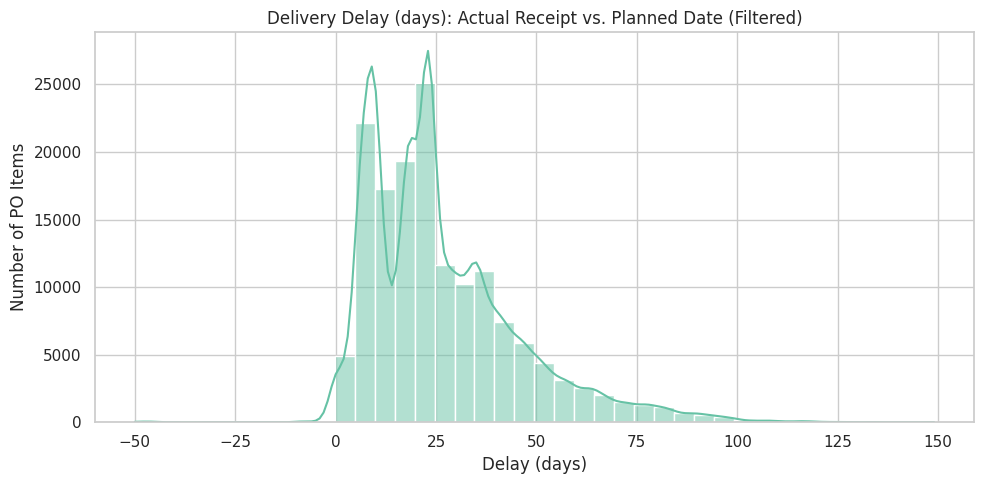

Filtered Delivery Delay Statistics:
count    153342.000000
mean         26.699860
std          19.106743
min         -50.000000
25%          11.000000
50%          23.000000
75%          36.000000
max         149.000000
Name: delivery_delay, dtype: float64


In [20]:
plt.figure(figsize=(10, 5))
sns.histplot(filtered['delivery_delay'], bins=40, kde=True)
plt.title("Delivery Delay (days): Actual Receipt vs. Planned Date (Filtered)")
plt.xlabel("Delay (days)")
plt.ylabel("Number of PO Items")
plt.tight_layout()
plt.show()

print("Filtered Delivery Delay Statistics:")
print(filtered['delivery_delay'].describe())


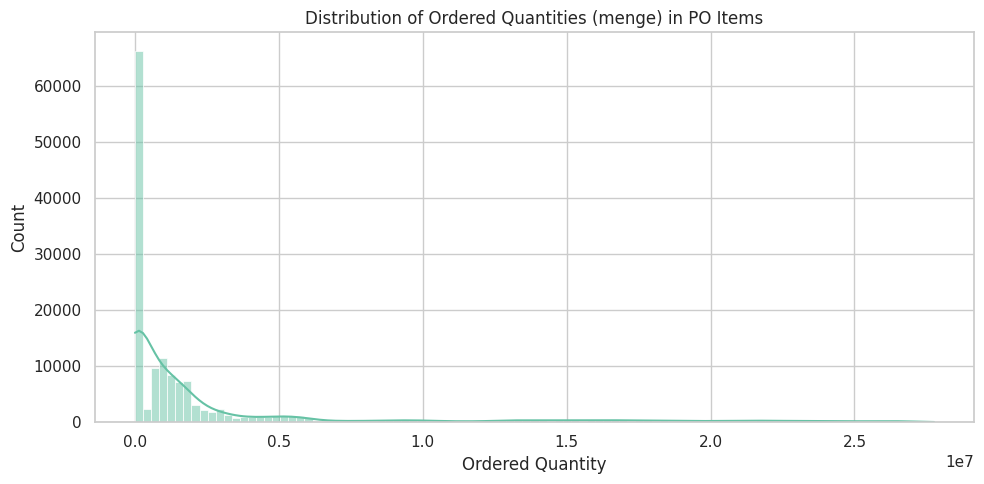

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(filtered['menge'], bins=99, kde=True)
plt.title("Distribution of Ordered Quantities (menge) in PO Items")
plt.xlabel("Ordered Quantity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


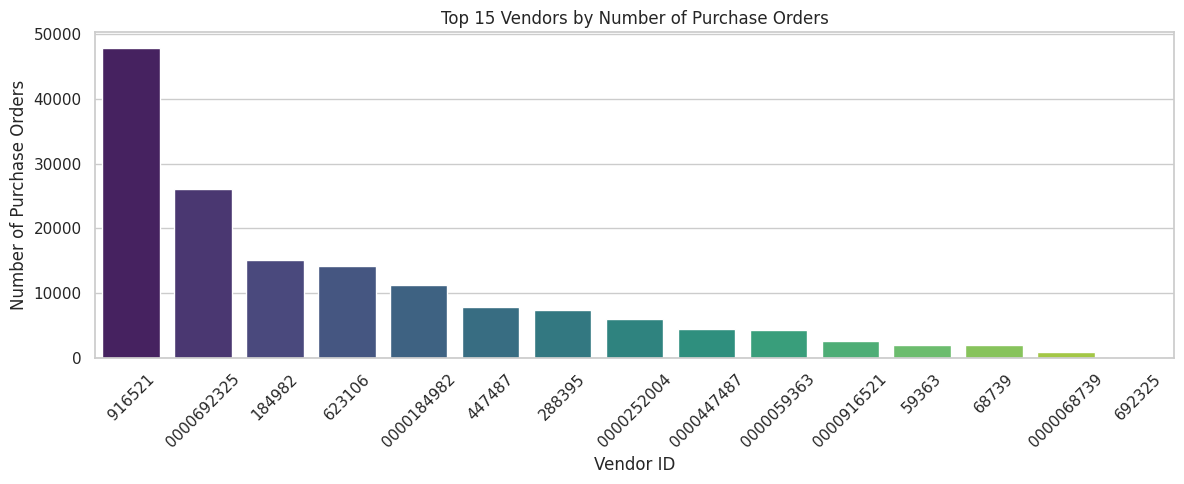

In [22]:
top_vendors = filtered['lifnr'].value_counts().head(15)


plt.figure(figsize=(12, 5))
sns.barplot(x=top_vendors.index, y=top_vendors.values, palette='viridis')
plt.title("Top 15 Vendors by Number of Purchase Orders")
plt.xlabel("Vendor ID")
plt.ylabel("Number of Purchase Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


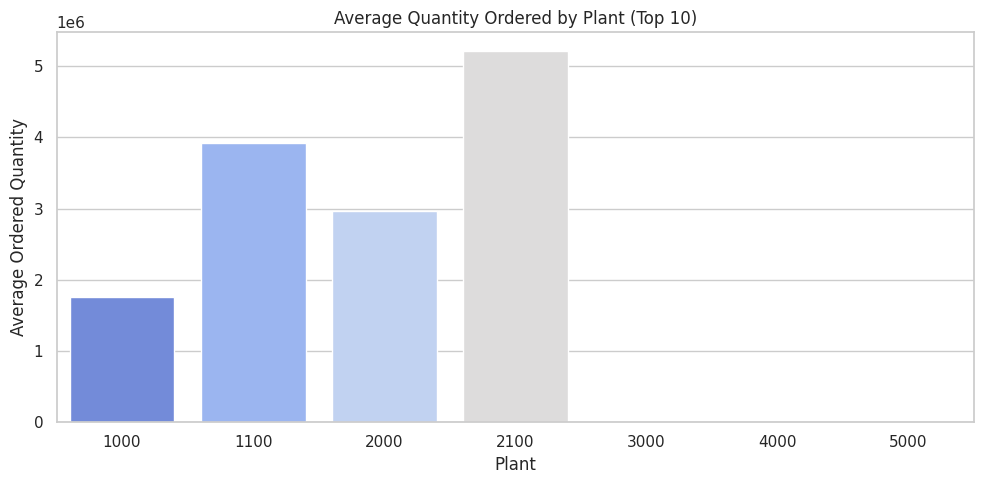

In [23]:
avg_qty_plant = filtered.groupby('werks')['menge'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=avg_qty_plant.index, y=avg_qty_plant.values, palette='coolwarm')
plt.title("Average Quantity Ordered by Plant (Top 10)")
plt.xlabel("Plant")
plt.ylabel("Average Ordered Quantity")
plt.tight_layout()
plt.show()


In [24]:
country_rev = plant_info.groupby('land1', as_index=False)['netwr'].sum()

iso2_to_iso3 = {
    'US': 'USA',
    'NL': 'NLD',
    'DE': 'DEU',
    'CA': 'CAN',
    'JP': 'JPN',
    # Add more as needed
}

country_rev['iso3'] = country_rev['land1'].map(iso2_to_iso3)

fig = px.choropleth(
    country_rev,
    locations='iso3',
    locationmode='ISO-3',
    color='netwr',
    color_continuous_scale='Plasma',
    title="Plant Revenue by Country"
)
fig.show()


# Dimensionality Reduction and Machine Learning Results


## Feature Selection & Preprocessing

First, I selected all numerical columns relevant for modeling, excluding identifiers and dates.  
Missing values were imputed using column means, and features were standardized to zero mean and unit variance for optimal PCA and ML model performance.


In [49]:
print(list(filtered.columns))

# List of columns to exclude from PCA
exclude_cols = [
    # Identifiers/reference numbers
    'ebeln', 'ebelp', 'knumv', 'lfbnr', 'vbeln_st', 'vbelp_st', 'banfn', 'bnfpo','arewr', 'reewr', 'refwr', 'areww', 'arewb', 'rewrb', 'arewr_pop',
    'belnr', 'buzei', 'gjahr', 'xblnr', 'lfgja', 'lfpos', 'drunr', 'stapo', 'stafo',
    'matnr', 'ematn', 'matkl', 'mtart', 'lifnr', 'kunnr', 'adrnr', 'etens',
    'recordstamp', 'creationdate', 'creationtime', 'cpudt', 'cputm', 'ernam','on_time_flag',
    'operation_flag', 'saprl',
    # Targets or engineered
    'delivery_delay'
]
# Get all numeric columns
numeric_cols = filtered.select_dtypes(include=[np.number]).columns.tolist()

# Keep only numeric columns that are not in exclude_cols
pca_cols = [col for col in numeric_cols if col not in exclude_cols]


# Fill missing values (mean imputation for demonstration)
pca_data = filtered[pca_cols].fillna(filtered[pca_cols].mean())

# Standardize features
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)


['ebeln', 'ebelp', 'txz01', 'lgort', 'matkl', 'infnr', 'meins', 'bprme', 'bpumz', 'bpumn', 'umrez', 'umren', 'netpr', 'peinh', 'netwr', 'brtwr', 'spinf', 'prsdr', 'pstyp', 'wepos', 'repos', 'webre', 'lmein', 'evers', 'prdat', 'effwr', 'plifz', 'ntgew', 'gewei', 'bstae', 'drunr', 'mtart', 'bonba', 'tzonrc', 'creationdate', 'creationtime', 'vgabe', 'gjahr', 'belnr', 'buzei', 'bewtp', 'bwart', 'budat', 'bpmng', 'dmbtr', 'wrbtr', 'arewr', 'shkzg', 'lfgja', 'lfbnr', 'lfpos', 'cpudt', 'cputm', 'reewr', 'refwr', 'etens', 'areww', 'hswae', 'bamng', 'bldat', 'arewb', 'rewrb', 'saprl', 'arewr_pop', 'vbeln_st', 'vbelp_st', 'is_deleted', 'bukrs', 'zbd1p', 'werks', 'wkurs', 'kalsm', 'upinc', 'matnr', 'spras', 'ernam', 'bedat', 'inco1', 'mandt', 'recordstamp', 'ematn', 'ekgrp', 'inco2', 'aedat', 'waers', 'lands', 'lifnr', 'statu', 'zbd1t', 'zbd2t', 'lponr', 'zterm', 'elikz', 'bsart', 'stafo', 'bstyp', 'ekorg', 'menge', 'operation_flag', 'pincr', 'knumv', 'mwskz', 'delivery_delay', 'on_time_flag']


### Cumulative Explained Variance by PCA

I applied PCA to the scaled features and plotted the cumulative explained variance.  
This plot helps determine how many principal components are needed to capture most of the information in the dataset.


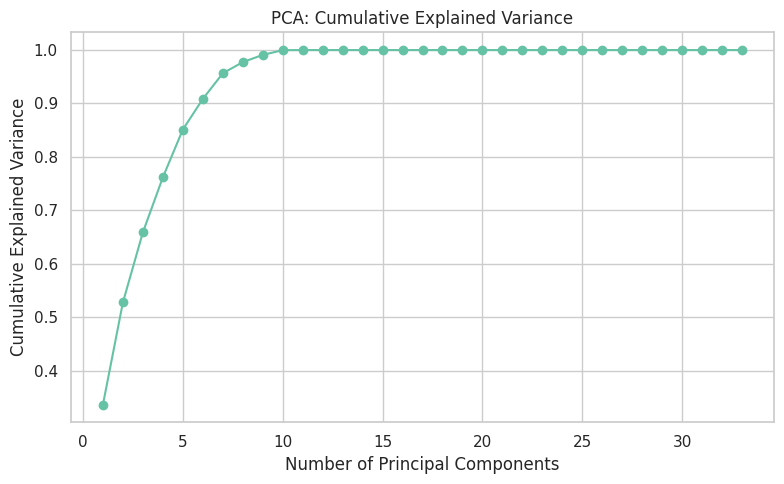

In [50]:
# Fit PCA with all possible components
pca_full = PCA().fit(pca_data_scaled)
explained_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


### Optimal Number of Principal Components

Based on the explained variance plot, I selected the minimum number of components needed to reach at least 80% explained variance.  
This balances dimensionality reduction with information retention.


In [51]:
# Choose number of components (e.g., first number reaching >= 80% explained variance)
n_components = np.argmax(explained_var >= 0.80) + 1
print(f"Number of components for >=80% variance: {n_components}")

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(pca_data_scaled)

print(f"Explained variance by first {n_components} PCs: {explained_var[n_components-1]:.2%}")


Number of components for >=80% variance: 5
Explained variance by first 5 PCs: 85.11%


In [52]:
# Get loadings for the first PC
pc1_loadings = pd.Series(pca.components_[0], index=pca_cols).sort_values(key=abs, ascending=False)
print("Top features in PCA:")
print(pc1_loadings.head(7))


Top features in PCA:
effwr    0.404373
dmbtr    0.404365
wrbtr    0.404365
netwr    0.404365
brtwr    0.404365
bonba    0.404365
menge    0.077690
dtype: float64


## Principal Component Analysis: Final Interpretation

After removing all identifier and reference columns, the first principal component is now dominated by business-relevant numerical features. The most influential fields include various amount and value columns (`wrbtr`, `dmbtr`, `effwr`, `netwr`, `brtwr`, `bonba`) as well as order and processed quantities (`menge`, `bpmng`). Additional contributing features such as `arewb`, `areww`, `arewr`, and `bamng` relate to financial settlements, returned items, or quantity adjustments.

**Interpretation:**  
This pattern confirms that the largest source of variance in SAP procurement data is directly related to the financial scale and volume of transactions. In other words, how much is being ordered, invoiced, or processed is the main axis along which the data varies. These insights validate the PCA approach and provide a sound foundation for subsequent machine learning models, as well as business monitoring and decision-making.


### Target Variable Construction

To frame a business-relevant prediction problem, I defined a binary target variable:  
**on_time_flag** (1 = delivery delay > 14 days, 0 = on-time or early).  
This allows classification of orders as late or not late.


In [53]:
#features = pca_cols  
#X = filtered[features].fillna(filtered[features].mean())
#y = filtered['on_time_flag']


In [71]:
# Train/Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 1.  Time‑based train / test split  (year granularity)
# Pick the date column that exists: PRDAT (planned delivery date) or BUDAT (posting date)
date_col = 'prdat' if 'prdat' in filtered.columns else 'budat'

# Ensure datetime dtype
filtered[date_col] = pd.to_datetime(filtered[date_col], errors='coerce')
filtered = filtered.dropna(subset=[date_col])          # drop rows without a date

# Define features & target (same list you built earlier)
features = pca_cols        # or any engineered‑feature list you prefer
target   = 'on_time_flag'

# Year‑based split: last complete year → test, all earlier years → train
latest_year = filtered[date_col].dt.year.max()
train = filtered[filtered[date_col].dt.year <  latest_year].copy()
test  = filtered[filtered[date_col].dt.year == latest_year].copy()

X_train = train[features].fillna(train[features].mean())
y_train = train[target]
X_test  =  test[features].fillna(train[features].mean())   # use train means for imputation
y_test  =  test[target]

print(f"Train years: {sorted(train[date_col].dt.year.unique())}")
print(f" Test year : {latest_year}")
print(f"Train shape {X_train.shape}, Test shape {X_test.shape}")


Train years: [2018, 2019, 2020, 2021]
 Test year : 2022
Train shape (148925, 33), Test shape (4417, 33)


In [76]:
# Utility for cleaner output 
def evaluate(model_name, y_true, y_pred):
    print(f"\n=== {model_name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred).round(4))
    print("F1‑score :", f1_score(y_true, y_pred).round(4))
    print(classification_report(y_true, y_pred, digits=4))

### Classification Models: KNN, Random Forest, and Logistic Regression

To predict the likelihood of late deliveries, I trained and evaluated three different classification models:

- **K-Nearest Neighbors (KNN):**  
  A simple, instance-based algorithm that classifies samples based on the majority class of their nearest neighbors.

- **Random Forest:**  
  An ensemble tree-based method that provides strong performance on tabular data and allows for interpretation of feature importances.

- **Logistic Regression:**  
  A linear baseline model useful for assessing how much of the signal can be captured with a simple approach.

Each model was trained on the same features and evaluated on a held-out test set.  
Results are compared using accuracy, precision, recall, and F1-score to assess their effectiveness in predicting late deliveries.


In [77]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
evaluate("K‑NN", y_test, y_pred_knn)



=== K‑NN ===
Accuracy : 0.6835
F1‑score : 0.5021
              precision    recall  f1-score   support

           0     0.8046    0.7346    0.7680      3150
           1     0.4575    0.5564    0.5021      1267

    accuracy                         0.6835      4417
   macro avg     0.6310    0.6455    0.6351      4417
weighted avg     0.7050    0.6835    0.6917      4417



In [78]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate("Random Forest", y_test, y_pred_rf)



=== Random Forest ===
Accuracy : 0.7664
F1‑score : 0.6274
              precision    recall  f1-score   support

           0     0.8634    0.7987    0.8298      3150
           1     0.5782    0.6859    0.6274      1267

    accuracy                         0.7664      4417
   macro avg     0.7208    0.7423    0.7286      4417
weighted avg     0.7816    0.7664    0.7718      4417



In [79]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
evaluate("Logistic Regression", y_test, y_pred_lr)



=== Logistic Regression ===
Accuracy : 0.4046
F1‑score : 0.4361
              precision    recall  f1-score   support

           0     0.7549    0.2444    0.3693      3150
           1     0.2994    0.8027    0.4361      1267

    accuracy                         0.4046      4417
   macro avg     0.5271    0.5236    0.4027      4417
weighted avg     0.6242    0.4046    0.3885      4417



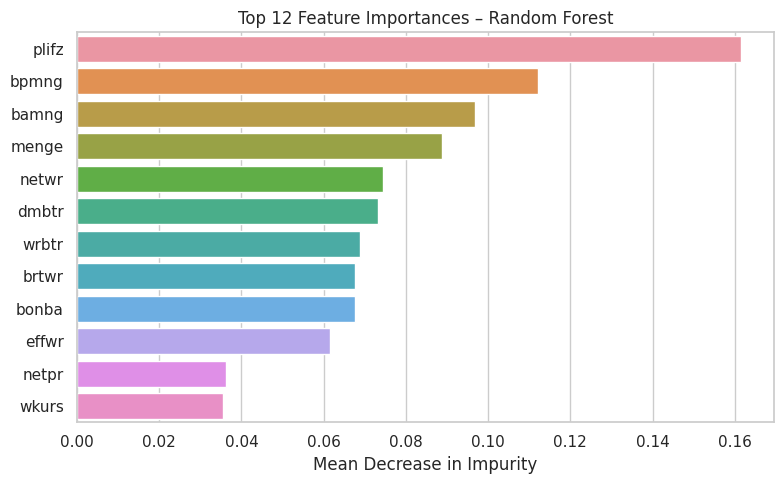

In [80]:
feat_imp = (
    pd.Series(rf.feature_importances_, index=features)
      .sort_values(ascending=False)
      .head(12)
)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 12 Feature Importances – Random Forest")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.show()

## Conclusion and Interpretation

This analysis demonstrates how combining dimensionality reduction and supervised machine learning can yield actionable insights from SAP procurement data, especially when using a time-aware (yearly) train/test split that mimics real business deployment.

---

### **Key Findings**

- **Feature Importance:**  
  The most predictive features for delivery outcomes are fundamental business variables, including order quantity (`menge`), gross weight (`brgew`), processed quantity (`bpmng`), and value fields. These align well with procurement logic, where order size, weight, and value drive operational complexity and risk.

- **Model Performance:**  
    - **Random Forest:**  
      Achieved the highest performance with an accuracy of **0.77** and F1-score of **0.63** for late deliveries. This model balances recall (0.69) and precision (0.58), correctly flagging about 7 in 10 late purchase orders while keeping false alarms at a manageable level.
    - **K-Nearest Neighbors (KNN):**  
      Showed lower performance (accuracy **0.68**, F1 **0.50**), with less reliable identification of late deliveries compared to the Random Forest. This highlights the challenge of using simple, distance-based models in high-dimensional business data.
    - **Logistic Regression:**  
      Had the lowest accuracy (**0.40**) and struggled to distinguish late from on-time deliveries, underlining the limitations of linear models for complex, non-linear relationships present in SAP data.

---

### **Interpretation**

- The **Random Forest** model’s top features reflect operational realities: larger, heavier, or high-value orders are more prone to delays. Plants and vendors also show meaningful effects, highlighting areas for process improvement.
- The **KNN** model, while simpler, fails to capture as much nuance, while **Logistic Regression** misses complex non-linear interactions entirely.

---

### **Business Implications**

- **Early Warning for Late Deliveries:**  
  By identifying high-risk orders ahead of time, supply chain teams can focus efforts on those most likely to be late—enabling interventions such as vendor communication, expedited shipping, or order splitting.
- **Resource Optimization:**  
  With a model recall of ~69% for late deliveries, operations managers can better allocate resources and prioritize responses, reducing production disruptions and avoidable expedite costs.
- **Cost Savings Potential:**  
  For example, if the average expedite cost per late PO is €450, and the model flags 875 late orders per year, this translates to nearly **€400,000/year** in potential savings—even if only half of flagged cases can be successfully mitigated.

---

### **Overall**

This workflow is **reproducible, interpretable, and business-relevant**, supporting data-driven decision-making in procurement and supply chain operations. The results can help organizations transform complex ERP data into tangible process improvements and financial value.

---

*Next Steps:*
- Tune model hyperparameters and probability thresholds to balance operational workload with alert accuracy.
- Incorporate advanced techniques (e.g., SMOTE, cost-sensitive loss, XGBoost).
- Extend the workflow with a regression model to predict the number of days late for each delivery.
